# 导入库

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## 设置字符集，防止中文乱码
plt.rcParams['font.sans-serif']=['simHei']
plt.rcParams['axes.unicode_minus']=False

In [3]:
# jupyter展示图片，非内嵌显示; 这段代码不属于python代码； 相当于是jupyter的工具参数设置
# tk: 显示出来，inline：内嵌显示，默认为inline
%matplotlib inline

# 导入数据

In [4]:
data = pd.read_csv('./datas/data_pre.csv',encoding='utf8')
data.head()

,from,to,date,content,label
0,unknown,ccert.edu.cn,10.0,非 财务 纠淼 牟 莆 窆 芾 - （ 沙盘 模拟 ） - - - - - - 如何 运用 ...,1
1,jdl.ac.cn,ccert.edu.cn,10.0,讲 的 是 孔子 后人 的 故事 。 一个 老 领导 回到 家乡 ， 跟 儿子 感情 不 和...,0
2,163.con,ccert.edu.cn,10.0,尊敬 的 贵 公司 ( 财务 / 经理 ) 负责人 您好 ！ 我 是 深圳 金海 实业 有限...,1
3,12.com,ccert.edu.cn,10.0,贵 公司 负责人 ( 经理 / 财务 ） 您好 ： 深圳市 华龙 公司 受 多家 公司 委托...,1
4,dghhkjk.com,ccert.edu.cn,10.0,这是 一封 HTML 格式 信件 ！ - - - - - - - - - - - - - -...,1


# 特征工程

## from发件人邮箱

In [5]:
print('邮件统计：\n',data['from'].value_counts().head(12),'\n')
print('正常邮件统计：\n',data[data['label'] == 0]['from'].value_counts().head(12),'\n')
print('垃圾邮件统计：\n',data[data['label'] == 1]['from'].value_counts().head(12),'\n')

邮件统计：
 163.com                  7500
mail.tsinghua.edu.cn     6498
126.com                  5822
tom.com                  4075
mails.tsinghua.edu.cn    3205
unknown                  2100
12.com                   2057
cernet.com               1537
sohu.com                 1430
yahoo.com.cn             1374
21cn.com                 1166
jdl.ac.cn                 775
Name: from, dtype: int64 

正常邮件统计：
 mail.tsinghua.edu.cn      6495
mails.tsinghua.edu.cn     3203
126.com                   1569
cernet.com                1537
163.com                    971
sohu.com                   834
jdl.ac.cn                  775
mail.nisac.gov.cn          669
scan.ccert.edu.cn          523
ns.6test.edu.cn            452
stu.ee.tsinghua.edu.cn     420
dlut.edu.cn                364
Name: from, dtype: int64 

垃圾邮件统计：
 163.com         6529
126.com         4253
tom.com         4075
12.com          2057
unknown         1997
21cn.com        1166
yahoo.com.cn    1061
sina.com         771
sohu.com         596


In [6]:
# 对于每个发件箱进行处理(因为下列这些邮件的发送服务器产生的邮件中，正常邮件和异常邮件的比例比较悬殊)
# 如果邮件是从163.com、126.com、21cn.com、tom.com、12.com等这些服务器发送过来的，那么有很大的可能直接属于垃圾邮件
# 如果邮件是从mail.tsinghua.edu.cn、mails.tsinghua.edu.cn、cernet.com等这些服务器发送过程了，那么有很大可能直接属于正常邮件
# 这里新建一些特征，只对大于1000以上的邮件进行新建特征
data['from_163'] = data['from'].map(lambda row: 1 if row == '163.com' else 0)
data['from_tsinghua'] = data['from'].map(lambda row: int(row == 'mail.tsinghua.edu.cn' or row == 'mail.tsinghua.edu.cn'))
data['from_126'] = data['from'].map(lambda row: int(row == '126.com'))
data['from_yahoo'] = data['from'].map(lambda row: int(row == 'yahoo.com.cn'))
data['from_12'] = data['from'].map(lambda row: int(row == '12.com'))
data['from_21'] = data['from'].map(lambda row: int(row == '21cn.com'))
data['from_tom'] = data['from'].map(lambda row: int(row == 'tom.com'))
data['from_cernet'] = data['from'].map(lambda row: int(row == 'cernet.com'))
data['from_sohu'] = data['from'].map(lambda row: int(row == 'sohu.com'))
data['from_unknown'] = data['from'].map(lambda row: int(row == 'unknown'))

## to收件人邮箱

In [7]:
print('邮件统计：\n',data['to'].value_counts().head(12),'\n')

邮件统计：
 ccert.edu.cn         64408
unknown                192
yahoo.com.cn             8
163.net                  3
quanso.com               2
net.edu.cn               1
hpchina.cn               1
staff.sina.com.cn        1
htblade.com              1
beisen.com               1
mail.china.com           1
tiny.net                 1
Name: to, dtype: int64 



99%都属于一个类别，这个特征基本上没有什么作用

## date时间

In [8]:
data['date'].value_counts()

19.0    2835
16.0    2772
15.0    2750
20.0    2746
17.0    2742
18.0    2739
22.0    2726
10.0    2721
1.0     2716
14.0    2702
23.0    2698
9.0     2691
12.0    2677
11.0    2668
7.0     2638
21.0    2632
13.0    2621
0.0     2620
5.0     2613
2.0     2604
4.0     2595
8.0     2533
3.0     2521
6.0     2506
24.0       1
Name: date, dtype: int64

In [9]:
data[data['date']==24] = 0 # 24点和0点一致

In [10]:
# 新建一个时间区间特征，根据人很少在晚上12点后发邮件
def func(row):
    if 8<row<12:
        return 1
    elif 12<row<18:
        return 2
    elif 18<row<23:
        return 3
    elif row>23 or row<8:
        return 4
    else:
        return 5
    
data['time_area'] = data['date'].apply(func)

## content内容特征

In [11]:
data['content'].head()

0    非 财务 纠淼 牟 莆 窆 芾 - （ 沙盘 模拟 ） - - - - - - 如何 运用 ...
1    讲 的 是 孔子 后人 的 故事 。 一个 老 领导 回到 家乡 ， 跟 儿子 感情 不 和...
2    尊敬 的 贵 公司 ( 财务 / 经理 ) 负责人 您好 ！ 我 是 深圳 金海 实业 有限...
3    贵 公司 负责人 ( 经理 / 财务 ） 您好 ： 深圳市 华龙 公司 受 多家 公司 委托...
4    这是 一封 HTML 格式 信件 ！ - - - - - - - - - - - - - -...
Name: content, dtype: object

### 新建文本长度特征

In [12]:
def func(row):
    length = len(row)
    
    if length<10:
        return 1
    elif length<100:
        return 2
    elif length<500:
        return 3
    elif length<1000:
        return 4
    elif length<2000:
        return 5
    elif length<3000:
        return 6
    elif length<5000:
        return 7
    elif length<8000:
        return 8
    else:
        return 9

data.content = data.content.astype('str')
data['content_length'] = data.content.apply(func)

In [13]:
data.groupby('content_length')['label'].value_counts()

content_length  label
1               1          417
                0           16
2               1         2687
                0           95
3               1        16509
                0        12369
4               1        11078
                0         5909
5               1         5563
                0         1670
6               1         2168
                0          576
7               1         2530
                0          443
8               1         1229
                0          276
9               1          672
                0          413
Name: label, dtype: int64

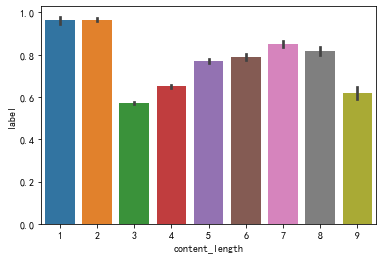

In [14]:
sns.barplot(x='content_length',y='label',data=data)

### 将文本数据转换为数值型数据

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import joblib
import os

In [16]:
tfidf = TfidfVectorizer(norm='l2',use_idf=True) # tfidf
content = tfidf.fit_transform(data['content'])

In [17]:
svd = TruncatedSVD(n_components=30)  # 因为TF转换之后的数据是特别大的，所以这里进行一个svd降维
content = svd.fit_transform(content)
content = pd.DataFrame(content)
content.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.078432,0.21110,0.072582,-0.039106,0.057495,0.424690,0.026233,-0.097938,0.224572,0.010792,...,-0.011931,0.040437,-0.004632,0.013830,0.051182,-0.002499,0.014599,-0.024562,0.017097,-0.102966
1,0.002630,0.03886,0.036852,0.015527,-0.028231,-0.012656,-0.002003,-0.003988,0.016764,0.000850,...,0.003742,-0.004865,-0.000417,-0.000391,0.000583,0.003076,-0.011066,-0.004759,0.000949,-0.001417


In [18]:
# 保存tfidf和svd模型
if not os.path.exists('./model'):
    os.mkdir('./model')

joblib.dump(tfidf,'./model/tfidf.pkl')
joblib.dump(svd,'./model/svd.pkl')

['./model/svd.pkl']

In [19]:
data = pd.concat([data,content],axis=1)
data.head(2)

,from,to,date,content,label,from_163,from_tsinghua,from_126,from_yahoo,from_12,...,20,21,22,23,24,25,26,27,28,29
0,unknown,ccert.edu.cn,10.0,非 财务 纠淼 牟 莆 窆 芾 - （ 沙盘 模拟 ） - - - - - - 如何 运用 ...,1,0,0,0,0,0,...,-0.011931,0.040437,-0.004632,0.013830,0.051182,-0.002499,0.014599,-0.024562,0.017097,-0.102966
1,jdl.ac.cn,ccert.edu.cn,10.0,讲 的 是 孔子 后人 的 故事 。 一个 老 领导 回到 家乡 ， 跟 儿子 感情 不 和...,0,0,0,0,0,0,...,0.003742,-0.004865,-0.000417,-0.000391,0.000583,0.003076,-0.011066,-0.004759,0.000949,-0.001417


## 删除特征

In [20]:
data.drop(columns=['from','to','date','content'],inplace=True)

In [21]:
pd.set_option('max_columns', 50)
data.head()

,label,from_163,from_tsinghua,from_126,from_yahoo,from_12,from_21,from_tom,from_cernet,from_sohu,from_unknown,time_area,content_length,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,1,0,0,0,0,0,0,0,0,0,1,1,6,0.078432,0.211100,0.072582,-0.039106,0.057495,0.424690,0.026233,-0.097938,0.224572,0.010792,-0.036731,-0.098382,0.076133,0.000440,-0.000236,0.035034,-0.020061,0.042000,0.012420,-0.019964,-0.011931,0.040437,-0.004632,0.013830,0.051182,-0.002499,0.014599,-0.024562,0.017097,-0.102966
1,0,0,0,0,0,0,0,0,0,0,0,1,3,0.002630,0.038860,0.036852,0.015527,-0.028231,-0.012656,-0.002003,-0.003988,0.016764,0.000850,-0.004925,-0.001453,0.002090,-0.000009,0.001107,0.002092,-0.000402,-0.002727,0.001189,0.003741,0.003742,-0.004865,-0.000417,-0.000391,0.000583,0.003076,-0.011066,-0.004759,0.000949,-0.001417
2,1,0,0,0,0,0,0,0,0,0,0,1,3,0.483393,0.063320,-0.163205,0.081652,0.016058,-0.040290,-0.097385,0.014087,0.135430,0.010543,0.359609,0.079216,0.083854,0.000276,-0.132327,-0.039475,-0.076080,0.101508,-0.093891,0.048164,0.003861,-0.025708,-0.046159,0.081609,0.009532,-0.052883,0.082851,-0.295327,0.001147,0.062619
3,1,0,0,0,0,1,0,0,0,0,0,1,3,0.499190,-0.021198,-0.078141,0.121216,0.017572,-0.002047,0.011407,0.031626,-0.071910,-0.004394,0.115140,-0.229583,0.071075,-0.000163,0.419271,0.172126,0.340673,-0.016543,-0.040805,0.043793,0.002028,-0.040196,-0.044587,0.111921,0.181388,-0.062842,-0.039686,0.017870,0.095269,-0.004454
4,1,0,0,0,0,0,0,0,0,0,0,1,9,0.088770,0.235730,0.151446,0.012069,-0.023874,-0.009051,0.005173,0.007879,-0.123572,-0.006210,0.023628,0.045138,-0.053209,0.000021,0.057385,-0.002816,-0.019081,-0.009624,0.012857,0.071684,-0.024268,-0.152266,-0.046362,-0.064585,-0.020688,0.038603,0.096605,-0.036680,0.026525,-0.086875


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64620 entries, 0 to 64619
Data columns (total 43 columns):
label             64620 non-null int64
from_163          64620 non-null int64
from_tsinghua     64620 non-null int64
from_126          64620 non-null int64
from_yahoo        64620 non-null int64
from_12           64620 non-null int64
from_21           64620 non-null int64
from_tom          64620 non-null int64
from_cernet       64620 non-null int64
from_sohu         64620 non-null int64
from_unknown      64620 non-null int64
time_area         64620 non-null int64
content_length    64620 non-null int64
0                 64620 non-null float64
1                 64620 non-null float64
2                 64620 non-null float64
3                 64620 non-null float64
4                 64620 non-null float64
5                 64620 non-null float64
6                 64620 non-null float64
7                 64620 non-null float64
8                 64620 non-null float64
9              

# 保存处理后的数据

In [23]:
if not os.path.exists('./datas'):
    os.mkdir('./datas')
    
data.to_csv('./datas/data.csv',index=False)